In [1]:
from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule, ImputationDataset
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.ops.imputation import add_missing_values
from MMD import mmd_rbf, mmd_linear
from tsl.engines import Imputer
from tsl.transforms import MaskInput
from tsl.nn.models import GRINModel
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tsl.utils.casting import torch_to_numpy
from tsl.metrics import torch as torch_metrics
import matplotlib.pyplot as plt
import torch


In [2]:
p_fault, p_noise = 0.0015, 0.05
dataset = add_missing_values(MetrLA(),
                                p_fault=p_fault,
                                p_noise=p_noise,
                                min_seq=12,
                                max_seq=12 * 4,
                                seed=56789)
    
adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = ImputationDataset(target=dataset.dataframe(),
                                    mask=dataset.training_mask,
                                    eval_mask=dataset.eval_mask,
                                    covariates=None,
                                    transform=MaskInput(),
                                    connectivity=adj,
                                    window=1,
                                    stride=1)


scalers = {'target': StandardScaler(axis=(0, 1))}
dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(**{'val_len': 0.2, 'test_len': 0.1}),
    batch_size=1,
    workers=8)
dm.setup(stage='fit')
dm.trainset = list(range(len(torch_dataset)))

/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/datasets/metr_la.py:96: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(datetime_idx[0],
/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/datasets/metr_la.py:109: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df = df.replace(to_replace=0., method='ffill')


In [3]:
loss_fn = torch_metrics.MaskedMAE()

# setup generator
imputer = Imputer.load_from_checkpoint('/data/p.magos/TSGen/logs/prediction/grinMetr/best-model-epoch=49-val_loss=554.3832.ckpt')

In [4]:
trainer = Trainer()

trainer.ckpt_path= '/data/p.magos/TSGen/logs/prediction/grinMetr/best-model-epoch=49-val_loss=554.3832.ckpt'

imputer.freeze()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
output = imputer.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true = (output['y_hat'], output['y'])
# res = dict(test_mae=loss_fn(torch.tensor(y_hat), y_true))
# res

Restoring states from the checkpoint path at /data/p.magos/TSGen/logs/prediction/grinMetr/best-model-epoch=49-val_loss=554.3832.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Loaded model weights from the checkpoint at /data/p.magos/TSGen/logs/prediction/grinMetr/best-model-epoch=49-val_loss=554.3832.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Only args ['x', 'edge_weight', 'edge_index', 'mask'] are forwarded to the model (GRINModel). 


TypeError: 'int' object is not callable

In [10]:
y_true = torch.tensor(y_true)
y_hat = torch.tensor(y_hat)
pred = scalers['target'].transform(y_hat)

/tmp/ipykernel_23808/189480785.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true)
/tmp/ipykernel_23808/189480785.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat = torch.tensor(y_hat)


In [12]:
X = y_true.reshape(y_true.shape[0], -1)
Y = scalers['target'].inverse_transform(pred)
Y = Y.reshape(y_true.shape[0], -1)
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.023926781490445137

In [13]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))

tensor(2120.0044)

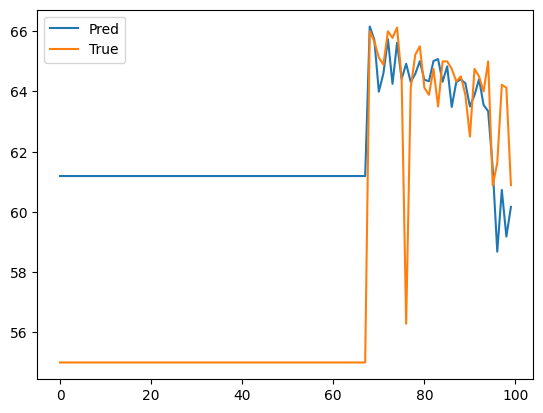

In [17]:
plt.plot(Y[:100, 100], label='Pred')
plt.plot(X[:100, 100], label='True')
plt.legend()

In [19]:
import pandas as pd

cols = [773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,765604,767471,716339,773906,765273,716331,771667,716337,769953,769402,769403,769819,769405,716941,717578,716960,717804,767572,767573,773012,773013,764424,769388,716328,717819,769941,760987,718204,718045,769418,768066,772140,773927,760024,774012,774011,767609,769359,760650,716956,769831,761604,717495,716554,773953,767470,716955,764949,773954,767366,769444,773939,774067,769443,767750,767751,767610,773880,764766,717497,717490,717491,717492,717493,765176,717498,717499,765171,718064,718066,765164,769431,769430,717610,767053,767621,772596,772597,767350,767351,716571,773023,767585,773024,717483,718379,717481,717480,717486,764120,772151,718371,717489,717488,717818,718076,718072,767455,767454,761599,717099,773916,716968,769467,717576,717573,717572,717571,717570,764760,718089,769847,717608,767523,716942,718090,769867,717472,717473,759591,764781,765099,762329,716953,716951,767509,765182,769358,772513,716958,718496,769346,773904,718499,764853,761003,717502,759602,717504,763995,717508,765265,773996,773995,717469,717468,764106,717465,764794,717466,717461,717460,717463,717462,769345,716943,772669,717582,717583,717580,716949,717587,772178,717585,716939,768469,764101,767554,773975,773974,717510,717513,717825,767495,767494,717821,717823,717458,717459,769926,764858,717450,717452,717453,759772,717456,771673,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373]
df = pd.DataFrame(Y, columns=cols)

In [20]:
df

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.777603,64.626968,66.516983,56.724983,58.994576,59.327736,63.425434,62.884956,62.132294,64.976036,...,43.785980,67.323807,61.383209,64.153946,66.021812,62.601936,66.970558,62.207912,66.562836,61.746437
1,64.777603,64.626968,66.516983,56.724983,58.994576,59.327736,63.425434,62.884956,62.132294,64.976036,...,43.785980,67.323799,61.383209,64.153946,66.021812,62.601936,66.970558,62.207912,66.562836,61.746437
2,64.777603,64.626968,66.516983,56.724983,58.994576,59.327736,63.425434,62.884956,62.132294,64.976036,...,43.785980,67.323799,61.383209,64.153946,66.021812,62.601936,66.970558,62.207912,66.562836,61.746437
3,64.777603,64.626968,66.516983,56.724983,58.994576,59.327736,63.425434,62.884956,62.132294,64.976036,...,43.785980,67.323799,61.383209,64.153946,66.021812,62.601936,66.970558,62.207912,66.562836,61.746437
4,64.777603,64.626968,66.516983,56.724983,58.994576,59.327736,63.425434,62.884956,62.132294,64.976036,...,43.785980,67.323799,61.383209,64.153946,66.021812,62.601936,66.970558,62.207912,66.562836,61.746437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422,65.771149,66.266495,68.120522,58.875359,64.112297,62.059704,63.951218,64.055107,62.600067,66.513428,...,46.782543,68.161018,64.239677,58.477001,66.770477,63.211647,67.131569,63.768265,67.725693,63.532093
3423,65.280029,66.201790,67.701942,58.311661,64.347061,61.590210,64.278008,64.307808,63.277225,67.381470,...,45.804996,67.888954,63.987484,57.503643,66.468079,63.842987,67.463242,65.001938,67.710266,63.106003
3424,65.822540,66.191429,67.252968,57.682190,63.614666,61.385548,64.230698,63.683815,61.878757,66.850708,...,46.984058,68.143600,62.380932,62.329704,67.049500,63.748436,67.792801,64.451813,67.570091,63.939579
3425,65.096001,65.407120,67.247292,58.235958,63.879086,61.531475,64.617989,63.503807,61.292938,67.002487,...,46.485115,68.459198,62.913712,61.810730,66.524818,64.358246,67.663658,63.905998,67.737198,64.306900


In [21]:
df.to_csv('pred_grin_metr.csv', index=False)